# Tutorial: applying excursion in 2 dimension
## (with GPyTorch)

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
#generic imports
import numpy as np
import datetime
import os
import json
import yaml
import math
import time
import torch
import gpytorch
import matplotlib.pyplot as plt
%matplotlib inline
np.warnings.filterwarnings('ignore')

#excursion package imports
import excursion

## Step 0: What is excursion?
You can find an explanation [here]()
#TO DO
Also, it is advisable to use a virtualenv with the following [requeriments](https://github.com/irinaespejo/excursion/blob/master/requeriments.txt)


## Step 1: Load

We need to initilize several things and with a specific structure so that it's readable:

-  **True/Black-box function** (this is not a tutorial using funcX, just a simple toy function is all we need) 
-  **Grid**: where do you want to search for next evaluation points?
-  **Gaussian Process**: which kernel and likelihood do you want to use?
-  **Algorithm Options**: which acquisition function? Do you want batch selection? How many points per batch? Which batch method selection?

There are many choices and a user might not know a priori what to use. That is why we have prepared a set of complete examples that you just have to load to get started. These pre-build examples are in `excursion/testcases/fast_2D.py`these `.py` scripts contain initialization for: true/black-box function and grid (the "numerical options"). The files in `excursion/testcases/algorithms/algorithm_specs.yml` are yaml files that contain prestablished Gaussian Processes and Algorithm Options (the "algorithm options"). This way of ordering the init step makes it easy to fix a numerical problem while trying different algorithm configurations and vice versa.

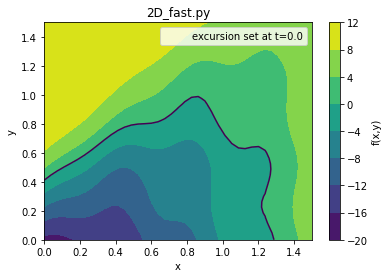

In [3]:
#load testcase
import excursion.testcases.fast_2D as testcase_details

for func in testcase_details.true_functions:
    ix,iy = testcase_details.plot_meshgrid
    X = testcase_details.X
    cont = excursion.utils.values2mesh(func(X), testcase_details.rangedef, testcase_details.invalid_region)
    levels = plt.contourf(ix,iy,cont)
    plt.contour(ix,iy,cont, levels = [0.], color='white')
    
levels.collections[0].set_label('excursion set at t='+str(testcase_details.thresholds.item()))
cbar = plt.colorbar(levels)
cbar.ax.set_ylabel('f(x,y)')
#approximate level set for plot purposes
plt.xlabel('x')
plt.ylabel('y')
plt.title('2D_fast.py')
plt.legend(loc=0)
plt.show()

In [4]:
#load algorithm options
file = open('../excursion/testcases/algorithms/algorithm_specs.yaml', "r")
algorithm_opts = yaml.safe_load(file)
print('algorithm_opts =')
print(json.dumps(algorithm_opts, indent=4))

algorithm_opts =
{
    "example": "1Dtoyanalysis",
    "ninit": 2,
    "nupdates": 35,
    "init_type": "random",
    "likelihood": {
        "type": "GaussianLikelihood",
        "epsilon": 0.0
    },
    "model": {
        "type": "GridGP",
        "kernel": "RBF",
        "prior": "Constant"
    },
    "acq": {
        "acq_type": "MES",
        "batch": true,
        "batchtype": "KB",
        "batchsize": 2
    }
}


## Step 2: Init the Gaussian Proces

We initialize the gaussian process and likelihood according to `algorithm_opts['init_type']`

In [5]:
#is there GPU?
if (torch.cuda.is_available()):
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

from excursion import init_gp
model, likelihood = init_gp(testcase_details, \
                            algorithm_opts, \
                            algorithm_opts["ninit"], \
                            device)

# X_init and y_init are random points so that we can fit the GP posterior wrt these points

X_init  tensor([[1.0875, 0.7500],
        [0.9750, 0.7125]], dtype=torch.float64)
y_init  tensor([ 1.1118, -0.9079], dtype=torch.float64)


In [6]:
# fit hyperparameters
model.train()
likelihood.train()
excursion.fit_hyperparams(model,likelihood)

<module 'matplotlib.pyplot' from 'C:\\Users\\Tutrie\\anaconda3\\envs\\IRIS_excursion\\lib\\site-packages\\matplotlib\\pyplot.py'>

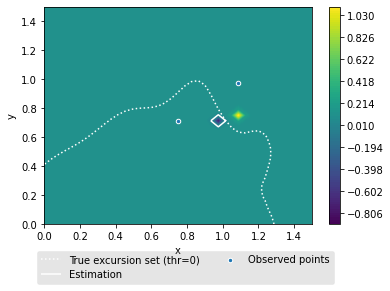

In [7]:
# plot the fitting
import excursion.plotting.twodim as plots
plots.plot_GP_init(plt, model, testcase_details, device=device, dtype=torch.float64)

## Step 3: Init the ExcursionEstimator

In [8]:
from excursion.estimator import ExcursionSetEstimator
# this object keeps internal track of the status of all objects involved
# in excursion at each step
estimator = ExcursionSetEstimator(testcase_details, \
                                  algorithm_opts, \
                                  model, \
                                  likelihood, \
                                  device)

## Step 4:  Smart grid search (active learning)

Iteration  1
x_new  torch.Size([2, 2]) tensor([[1.0125, 0.7125],
        [0.9750, 0.7500]], dtype=torch.float64)
y_new  torch.Size([2]) tensor([-0.0775, -0.4679], dtype=torch.float64)
pct  0.4229625223081499
Iteration  2
x_new  torch.Size([2, 2]) tensor([[1.0125, 0.9375],
        [1.2000, 0.6375]], dtype=torch.float64)
y_new  torch.Size([2]) tensor([ 1.7138, -0.0480], dtype=torch.float64)
pct  0.44854253420582985
Iteration  3
x_new  torch.Size([2, 2]) tensor([[0.8625, 1.0875],
        [1.1250, 1.1250]], dtype=torch.float64)
y_new  torch.Size([2]) tensor([1.2527, 2.7634], dtype=torch.float64)
pct  0.619274241522903
Iteration  4
x_new  torch.Size([2, 2]) tensor([[0.6750, 1.3500],
        [0.6375, 1.0125]], dtype=torch.float64)
y_new  torch.Size([2]) tensor([8.5701, 3.8963], dtype=torch.float64)
pct  0.6656751933372992
Iteration  5
x_new  torch.Size([2, 2]) tensor([[0.6000, 0.4875],
        [1.2000, 0.6750]], dtype=torch.float64)
y_new  torch.Size([2]) tensor([-6.4236,  0.2686], dtype=tor

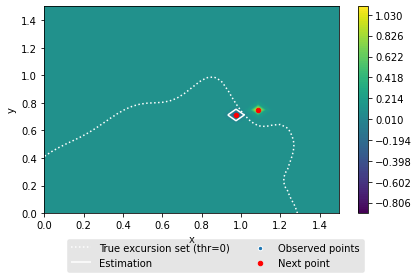

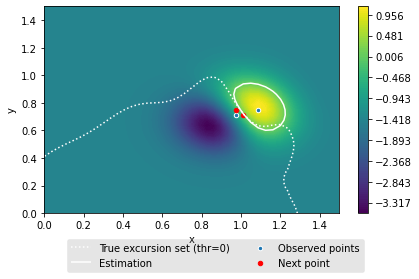

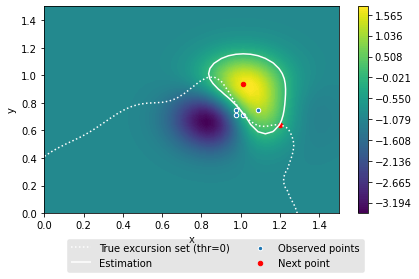

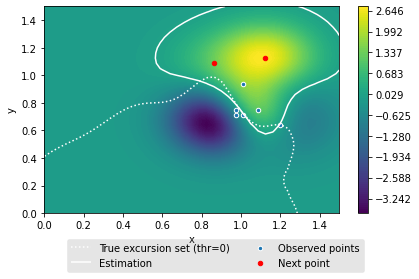

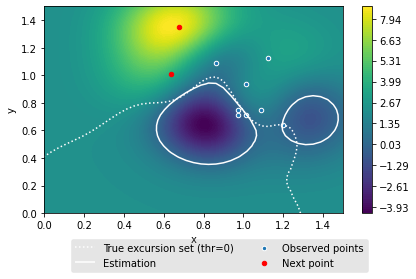

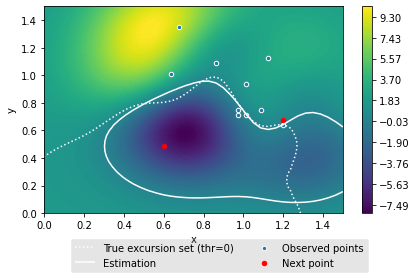

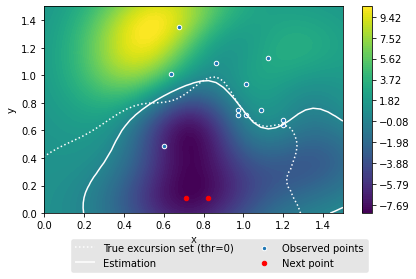

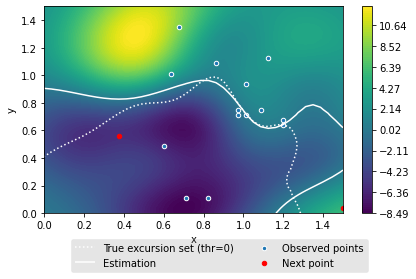

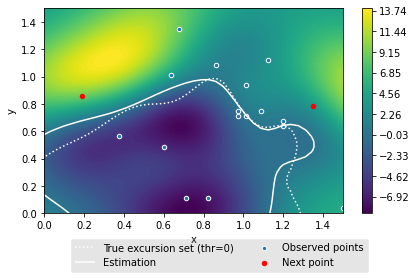

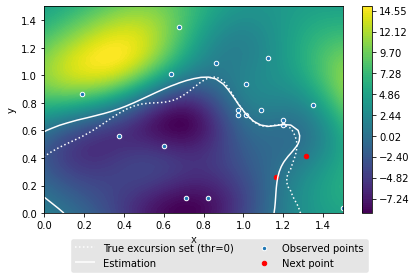

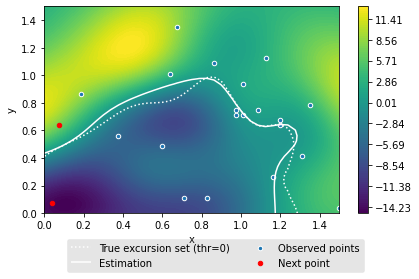

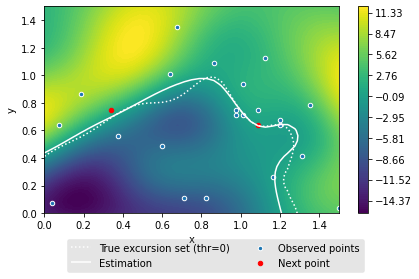

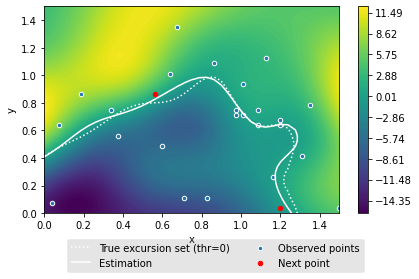

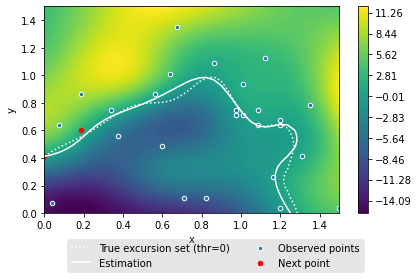

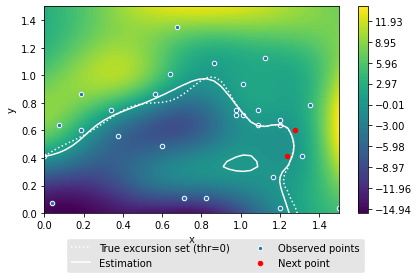

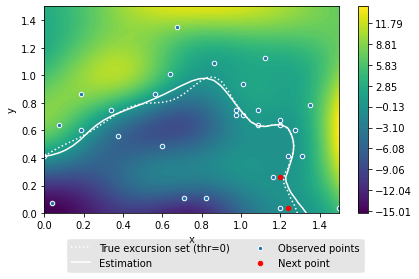

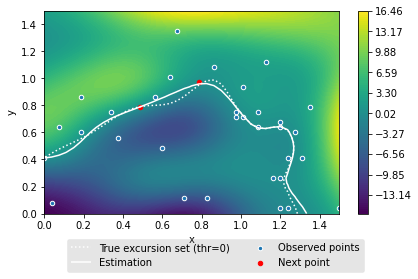

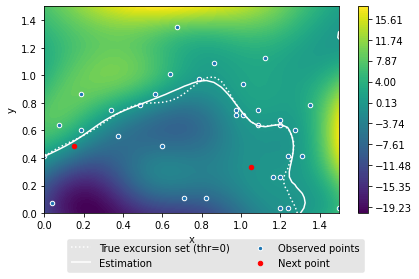

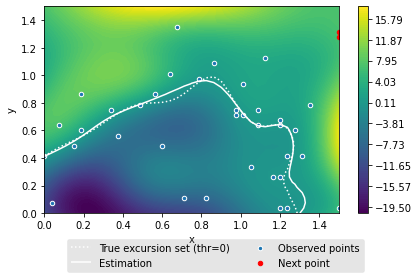

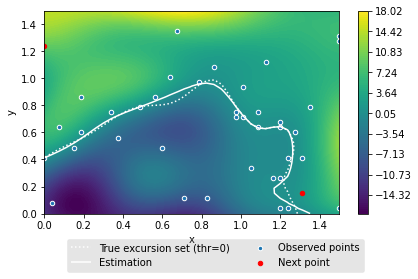

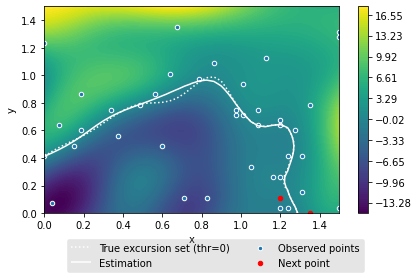

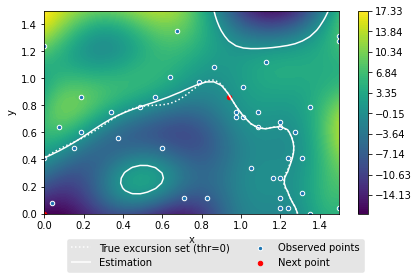

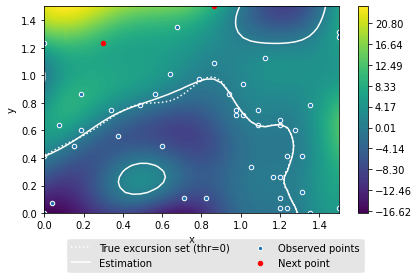

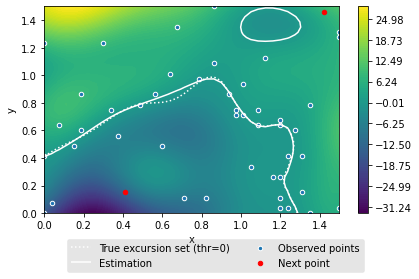

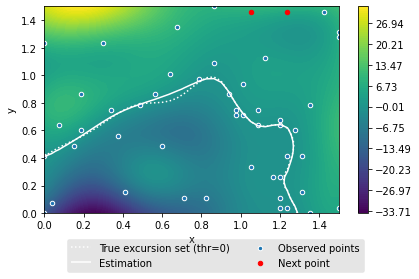

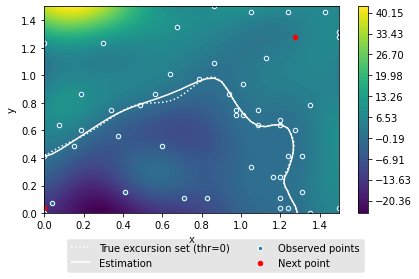

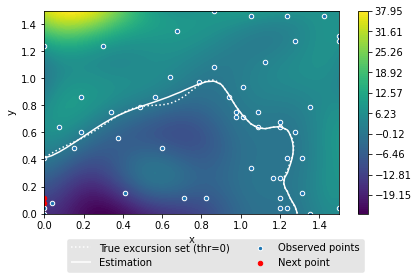

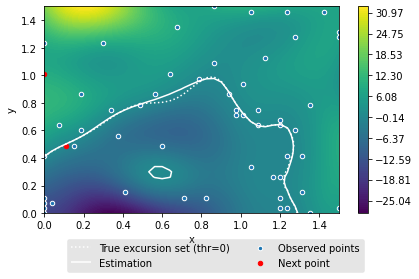

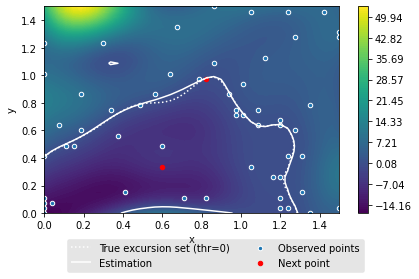

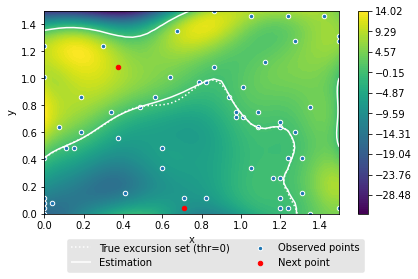

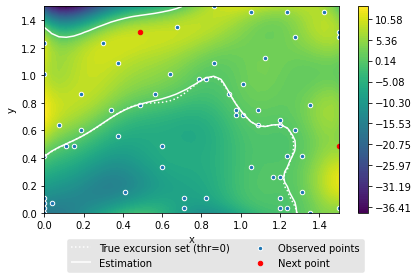

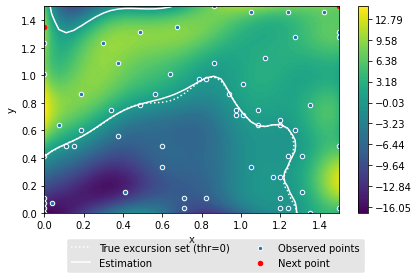

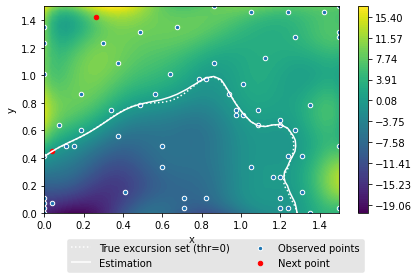

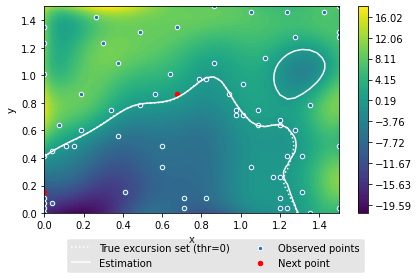

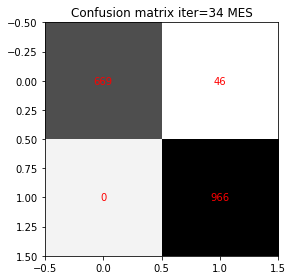

In [9]:
n_updates = algorithm_opts['nupdates']
#save results in folder
timestampStr = datetime.datetime.now().strftime('%d-%b-%Y_%H_%M_%S') + '\\'
outputfolder = r'C:\Users\Tutrie\Documents\IRIS-excursion\excursion_irina\examples\results'
outputfolder = os.path.join(outputfolder, timestampStr)
os.makedirs(outputfolder)

for iteration in range(1, n_updates+1):    
    #take a step forward: find new points to evaluate
    estimator.step(testcase_details, algorithm_opts, model, likelihood)
    
    #plot the new status
    estimator.plot_status(
            testcase_details, algorithm_opts, model, estimator.acq_values, outputfolder)
    
    #update the posterior of the GP wrt the new points
    model = estimator.update_posterior(testcase_details, algorithm_opts, model, likelihood)
    
    #get diagnostics (accuracy metric)
    estimator.get_diagnostics(testcase_details, model, likelihood)
    
#save results
estimator.print_results(outputfolder, testcase_details, algorithm_opts)